In [143]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast, CLIPImageProcessor
import os
from torch.utils.data import DataLoader
from datasets import load_metric
from datasets import load_dataset, DatasetDict, Dataset
import random
import numpy as np
import torch
from transformers import Trainer, TrainingArguments
import evaluate
from functools import partial

from transformers.tokenization_utils_base import BatchEncoding
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
from peft import LoraConfig, get_peft_model

In [70]:
os.environ["CURL_CA_BUNDLE"] = ""
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def seed_all(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
seed_all(69)

In [71]:
MODEL_NAME = "openai/clip-vit-base-patch32"

TOKENIZER = CLIPTokenizerFast.from_pretrained(MODEL_NAME)
IMAGE_PROCESSOR = CLIPImageProcessor.from_pretrained(MODEL_NAME)

### Dataset

In [77]:
dataset = load_dataset("pcuenq/oxford-pets")
dataset_train_val = dataset['train'].train_test_split(test_size=0.3)
dataset_val_test = dataset_train_val['test'].train_test_split(test_size=0.2)

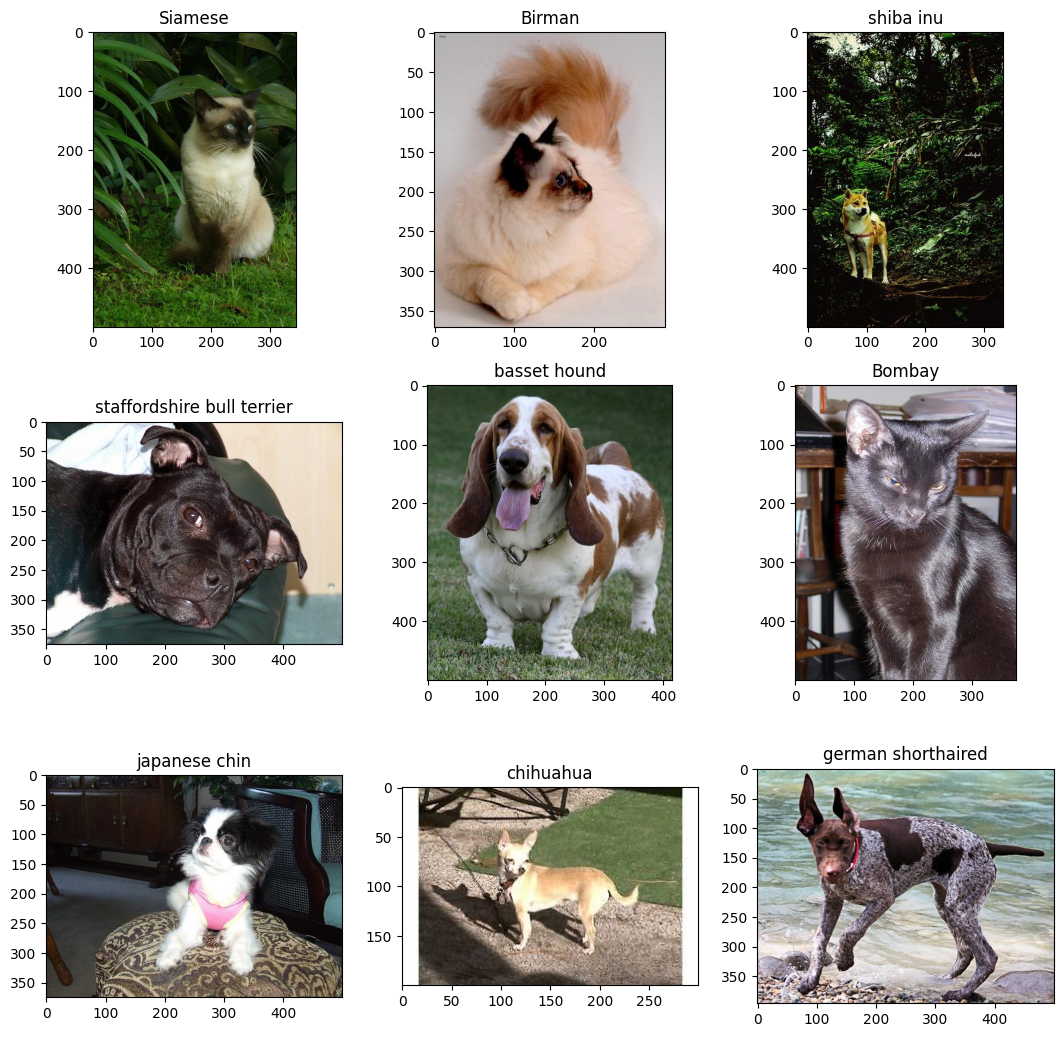

In [78]:
def show_images(ds: Dataset):
    fig, axs = plt.subplots(3, 3, figsize=(13, 13))
    for i in range(9):
        axs[i // 3][i % 3].imshow(ds[i]['image'])
        axs[i // 3][i % 3].set_title(ds[i]['label'])

show_images(dataset['train'])

In [79]:
dataset = DatasetDict(
    {
        "train": dataset_train_val['train'],  
        "val": dataset_val_test['test'],
        "test": dataset_val_test['train']
    }
)

In [81]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5173
    })
    val: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 444
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 1773
    })
})

In [82]:
labels = set(dataset['train']['label'])
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

labels = list(label2id)

In [83]:
def collate_fn(items):
    return {
        "pixel_values": torch.stack([item["pixel_values"] for item in items]), # (batch_size, 3, 224, 224)
        "input_ids": torch.tensor([item["input_ids"] for item in items]), # (batch_size, max_length)
        "attention_mask": torch.tensor([item["attention_mask"] for item in items]), # (batch_size, max_length)
        "label_id": torch.tensor([item["label_id"] for item in items]),
        "return_loss": True,
    }
    
def transform_class_labels(items, tokenizer: CLIPTokenizerFast, label2id: dict[str, int]):
    label_prompt = [f"a photo of {label}" for label in items['label']]
    output = tokenizer(label_prompt, padding=True, return_tensors='pt')
    items['input_ids'] = output['input_ids']
    items['attention_mask'] = output['attention_mask']
    items['label_id'] = [label2id[label] for label in items['label']]
    return items
    

def transform_image(items, image_processor: CLIPImageProcessor):
    output = image_processor(items['image'], return_tensors='pt')
    items['pixel_values'] = output['pixel_values']
    return items

In [84]:
dataset = dataset.map(partial(transform_class_labels, tokenizer=TOKENIZER, label2id=label2id), batched=True)
dataset.set_transform(partial(transform_image, image_processor=IMAGE_PROCESSOR))

Map:   0%|          | 0/5173 [00:00<?, ? examples/s]

Map:   0%|          | 0/444 [00:00<?, ? examples/s]

Map:   0%|          | 0/1773 [00:00<?, ? examples/s]

### CLIP Image Classification

In [85]:
def get_module_device(module: nn.Module) -> torch.device:
    return next(module.parameters()).device
    
def freeze_params(module: nn.Module, freeze_top_percent: float = 1.0):
    all_params_length = len(list(module.parameters()))
    for indx, param in enumerate(module.parameters(), 0):
        if int(all_params_length * freeze_top_percent) <= indx:
            break
        param.requires_grad = False
            

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {(trainable_params / 10**6):.4f}M || all params: {(all_param / 10**6):.4f}M || trainable%: {100 * trainable_params / all_param:.2f}%"
    )

    
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model: CLIPModel, tokenizer, labels: list[str]):
        super().__init__()
        self.model = clip_model
        self.tokenizer = tokenizer
        self.logit_scale = self.model.logit_scale.exp()
        self.label2id = {label: i for i, label in enumerate(labels)}
        self.labels_embeddings = nn.Parameter(self.generate_labels_embeddings(labels))

    def generate_labels_embeddings(self, labels: list[str]) -> BatchEncoding:
        labels_inputs = self.tokenizer([f"a photo of {label}" for label in labels], return_tensors='pt', padding=True).to(get_module_device(self.model))
        labels_embeddings = self.model.get_text_features(**labels_inputs)
        labels_embeddings /= labels_embeddings.norm(p=2, dim=-1, keepdim=True)
        return labels_embeddings
    
    def forward(self, images: torch.Tensor):
        image_features = self.model.get_image_features(images) # (batch_size, inner_dim)
        image_features /= image_features.norm(p=2, dim=-1, keepdim=True)
        return torch.matmul(image_features, self.labels_embeddings.T) * self.logit_scale

In [86]:
@torch.no_grad()
def calculate_accuracy(model: CLIPClassifier, dataloader: DataLoader, device: str):
    metric = load_metric("accuracy")
    predictions_list = []
    references_list = []
    for batch in tqdm(dataloader, total=len(dataloader), desc="Evaluate model on dataset"):
        batch['pixel_values'] = batch['pixel_values'].to(device)
        predictions = model(batch['pixel_values'])
        predictions_list.append(torch.argmax(predictions, dim=1))
        references_list.append(batch['label_id'])
    return metric.compute(predictions=torch.concat(predictions_list), references=torch.concat(references_list))

def evaluate_clip_classifier(model: nn.Module, dataset: Dataset, tokenizer: CLIPTokenizerFast, labels: list[str], device: str = "cuda"):
    clip_classifier = CLIPClassifier(model, tokenizer, labels)
    test_dataloader = DataLoader(dataset, batch_size=64, num_workers=5, collate_fn=collate_fn)
    clip_classifier = clip_classifier.to(device)
    acc = calculate_accuracy(clip_classifier, test_dataloader, device)
    print_trainable_parameters(model)
    print(f"Model accuracy: {acc}")

### Evaluate baseline CLIP (Zero-shot)

In [87]:
clip_baseline = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_baseline)
evaluate_clip_classifier(clip_baseline, dataset['test'], TOKENIZER, labels)

Evaluate model on dataset:   0%|          | 0/28 [00:00<?, ?it/s]

trainable params: 0.0000M || all params: 151.2773M || trainable%: 0.00%
Model accuracy: {'accuracy': 0.8155668358714044}


## Transfer learning

In [99]:
def collate_train_fn(items):
    items = collate_fn(items)
    items.pop("label_id")
    return items

def get_default_training_args(experiment_name: str, lr: float, batch_size: int=256, num_epoch: int = 2, num_workers: int = 15) -> TrainingArguments:
    return TrainingArguments(
        experiment_name,
        per_device_train_batch_size=batch_size,
        learning_rate=lr,
        num_train_epochs=num_epoch,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=1,
        logging_steps=10,
        save_total_limit=2,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        fp16=True,
        remove_unused_columns=False,
        load_best_model_at_end=True,
        dataloader_num_workers=num_workers,
    )
    

### All layers tuning

In [100]:
clip_full_finetuned = CLIPModel.from_pretrained(MODEL_NAME)

trainer = Trainer(
    model=clip_full_finetuned,
    args=get_default_training_args("clip-all-layers-tuning-oxford-pets", 3e-6),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.466000,2.278816
2,2.290600,2.239823


TrainOutput(global_step=42, training_loss=2.4073136761074974, metrics={'train_runtime': 46.7315, 'train_samples_per_second': 221.393, 'train_steps_per_second': 0.899, 'total_flos': 70339764267612.0, 'train_loss': 2.4073136761074974, 'epoch': 2.0})

In [101]:
evaluate_clip_classifier(clip_full_finetuned, dataset['test'], TOKENIZER, labels)

Evaluate model on dataset:   0%|          | 0/28 [00:00<?, ?it/s]

trainable params: 151.2773M || all params: 151.2773M || trainable%: 100.00%
Model accuracy: {'accuracy': 0.9396503102086858}


### Only text model tuning

In [102]:
clip_text_model_tuning = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_text_model_tuning.vision_model)

trainer = Trainer(
    model=clip_text_model_tuning,
    args=get_default_training_args("clip-text-model-tuning-oxford-pets", 3e-6),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.536400,2.367030
2,2.421700,2.323666


TrainOutput(global_step=42, training_loss=2.492161268279666, metrics={'train_runtime': 42.3054, 'train_samples_per_second': 244.555, 'train_steps_per_second': 0.993, 'total_flos': 70339764267612.0, 'train_loss': 2.492161268279666, 'epoch': 2.0})

In [103]:
evaluate_clip_classifier(clip_text_model_tuning, dataset['test'], TOKENIZER, labels)

Evaluate model on dataset:   0%|          | 0/28 [00:00<?, ?it/s]

trainable params: 63.8213M || all params: 151.2773M || trainable%: 42.19%
Model accuracy: {'accuracy': 0.9300620417371687}


### Only vision model tuning

In [104]:
clip_vision_model_tuning = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_vision_model_tuning.text_model)

trainer = Trainer(
    model=clip_vision_model_tuning,
    args=get_default_training_args("clip-vision-model-tuning-oxford-pets", 3e-5),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.543700,2.440598
2,2.251400,2.308811


TrainOutput(global_step=42, training_loss=2.469446273077102, metrics={'train_runtime': 44.3045, 'train_samples_per_second': 233.52, 'train_steps_per_second': 0.948, 'total_flos': 70339764267612.0, 'train_loss': 2.469446273077102, 'epoch': 2.0})

In [105]:
evaluate_clip_classifier(clip_vision_model_tuning, dataset['test'], TOKENIZER, labels)

Evaluate model on dataset:   0%|          | 0/28 [00:00<?, ?it/s]

trainable params: 88.1114M || all params: 151.2773M || trainable%: 58.24%
Model accuracy: {'accuracy': 0.9244218838127467}


### Tune top 20% of vision and text models

In [106]:
clip_partial_tuning = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_partial_tuning.text_model, freeze_top_percent=0.8)
freeze_params(clip_partial_tuning.vision_model, freeze_top_percent=0.8)

In [107]:
trainer = Trainer(
    model=clip_partial_tuning,
    args=get_default_training_args("clip-partial-model-tuning-oxford-pets", 3e-5),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.399300,2.232258
2,2.251600,2.183160


TrainOutput(global_step=42, training_loss=2.332585505076817, metrics={'train_runtime': 41.191, 'train_samples_per_second': 251.171, 'train_steps_per_second': 1.02, 'total_flos': 70339764267612.0, 'train_loss': 2.332585505076817, 'epoch': 2.0})

In [108]:
evaluate_clip_classifier(clip_partial_tuning, dataset['test'], TOKENIZER, labels)

Evaluate model on dataset:   0%|          | 0/28 [00:00<?, ?it/s]

trainable params: 27.9631M || all params: 151.2773M || trainable%: 18.48%
Model accuracy: {'accuracy': 0.9447264523406655}


### PEFT tuning (with Lora)

In [152]:
clip_lora_tuning = CLIPModel.from_pretrained(MODEL_NAME)
config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules=['q_proj', 'k_proj', 'v_proj'],
)

lora_model = get_peft_model(clip_lora_tuning, config)
print_trainable_parameters(lora_model)

trainable params: 5.8982M || all params: 157.1756M || trainable%: 3.75%


In [153]:
trainer = Trainer(
    model=lora_model,
    args=get_default_training_args("clip-lora-model-tuning-oxford-pets", 3e-4),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.408900,2.237647
2,2.269700,2.201469


Checkpoint destination directory clip-lora-model-tuning-oxford-pets/checkpoint-21 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory clip-lora-model-tuning-oxford-pets/checkpoint-42 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=42, training_loss=2.3336143039521717, metrics={'train_runtime': 47.4154, 'train_samples_per_second': 218.199, 'train_steps_per_second': 0.886, 'total_flos': 73635016583772.0, 'train_loss': 2.3336143039521717, 'epoch': 2.0})

In [154]:
evaluate_clip_classifier(lora_model, dataset['test'], TOKENIZER, labels)

Evaluate model on dataset:   0%|          | 0/28 [00:00<?, ?it/s]

trainable params: 5.8982M || all params: 157.1756M || trainable%: 3.75%
Model accuracy: {'accuracy': 0.9452904681331077}
